In [33]:
import numpy as np
from matplotlib import pyplot as plt
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.task import task_constants
from ephysvibe.structures.neuron_data import NeuronData
import platform

### Functions

## Block 1

In [34]:
if platform.system() == 'Linux':
    basepath = '/envau/'
elif platform.system() == 'Windows':
    basepath = 'D:/data/'#//envau_cifs.intlocal.univ-amu.fr/'

In [35]:
neu_path = basepath+"/session_struct/pfc/neurons/2022-12-05_10-51-52_Riesling_pfc_e1_r1_mua33_neu.h5"
neu_data = NeuronData.from_python_hdf5(neu_path)

In [37]:
# parameters
time_before=700
select_block=1
start=-200
end=1000
idx_start = time_before + start 
idx_end = time_before+end

In [38]:
# sp_sample_on_all=[]
conv_all={'in':{},'out':{}}
all_sp_by_sample = {'in':{},'out':{}}
pos_label = ['in','out']
pos_code = [1,-1]
# idx_tr_sample = []
count_trials=0
all_max_conv=0
all_max_trial=0

for code,pos in zip(pos_code,pos_label):
    # select correct trials, block one, inside/outside RF, and align with sample onset 
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )

    sample_id = neu_data.sample_id[mask]
    sp_by_sample = select_trials.get_sp_by_sample(sp_sample_on,sample_id)
    for key,value in sp_by_sample.items():
        arr = value.mean(axis=0)
        conv = firing_rate.convolve_signal(arr=arr,fs = 1000,w_size=0.1,w_std=0.015,axis=0)[idx_start:idx_end]
        conv_all[pos][key] = conv
        sp_by_sample[key]=value[:,idx_start:idx_end]
        count_trials= value.shape[0]
        max_conv = np.max(conv) 
        all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
        all_max_trial = count_trials if count_trials > all_max_trial else all_max_trial
    all_sp_by_sample[pos] = sp_by_sample
#sp_sample_on_in = sp_sample_on_in[:,0:1200+time_before]

In [39]:
# def conv_mean_trials_fr(arr,fs = 1000,w_size=0.1,w_std=0.015):
#     # define kernel for convolution
#     kernel = firing_rate.define_kernel(
#         w_size, w_std, fs=fs
#     )
#     mean_arr = arr.mean(axis=0)
#     conv = np.convolve(mean_arr, kernel, mode="same") * fs
#     return conv

In [40]:
def plot_raster_conv(sp_sample,start,conv,time,ax1,ax2,colors):
    n_trials=0
    for key,sp in sp_sample.items():
        # ----- plot conv----------
        if len(conv[key])==0:
            return ax1,ax2,0
        ax1.plot(time, conv[key], color=colors[key])
        # ----- plot spikes----------
        rows, cols = np.where(sp >= 1)
        ax2.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)
        n_trials = n_trials + sp.shape[0] 

    return ax1,ax2,n_trials

In [41]:
task_constants.PALETTE_B1

{'o1_c1': 'firebrick',
 'o1_c5': 'teal',
 'o5_c1': 'tomato',
 'o5_c5': 'lightseagreen',
 'o0_c0': 'grey'}

In [46]:
colors = {'11':task_constants.PALETTE_B1['o1_c1'],'15':task_constants.PALETTE_B1['o1_c5'],'51':task_constants.PALETTE_B1['o5_c1'],'55':task_constants.PALETTE_B1['o5_c5'],'0':task_constants.PALETTE_B1['o0_c0']}


C:\Users\camil\AppData\Local\Temp\ipykernel_28460\510088082.py:10: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)


Text(0.05, 0.99, '2022-12-05_10-51-52: pfc mua 33 ')

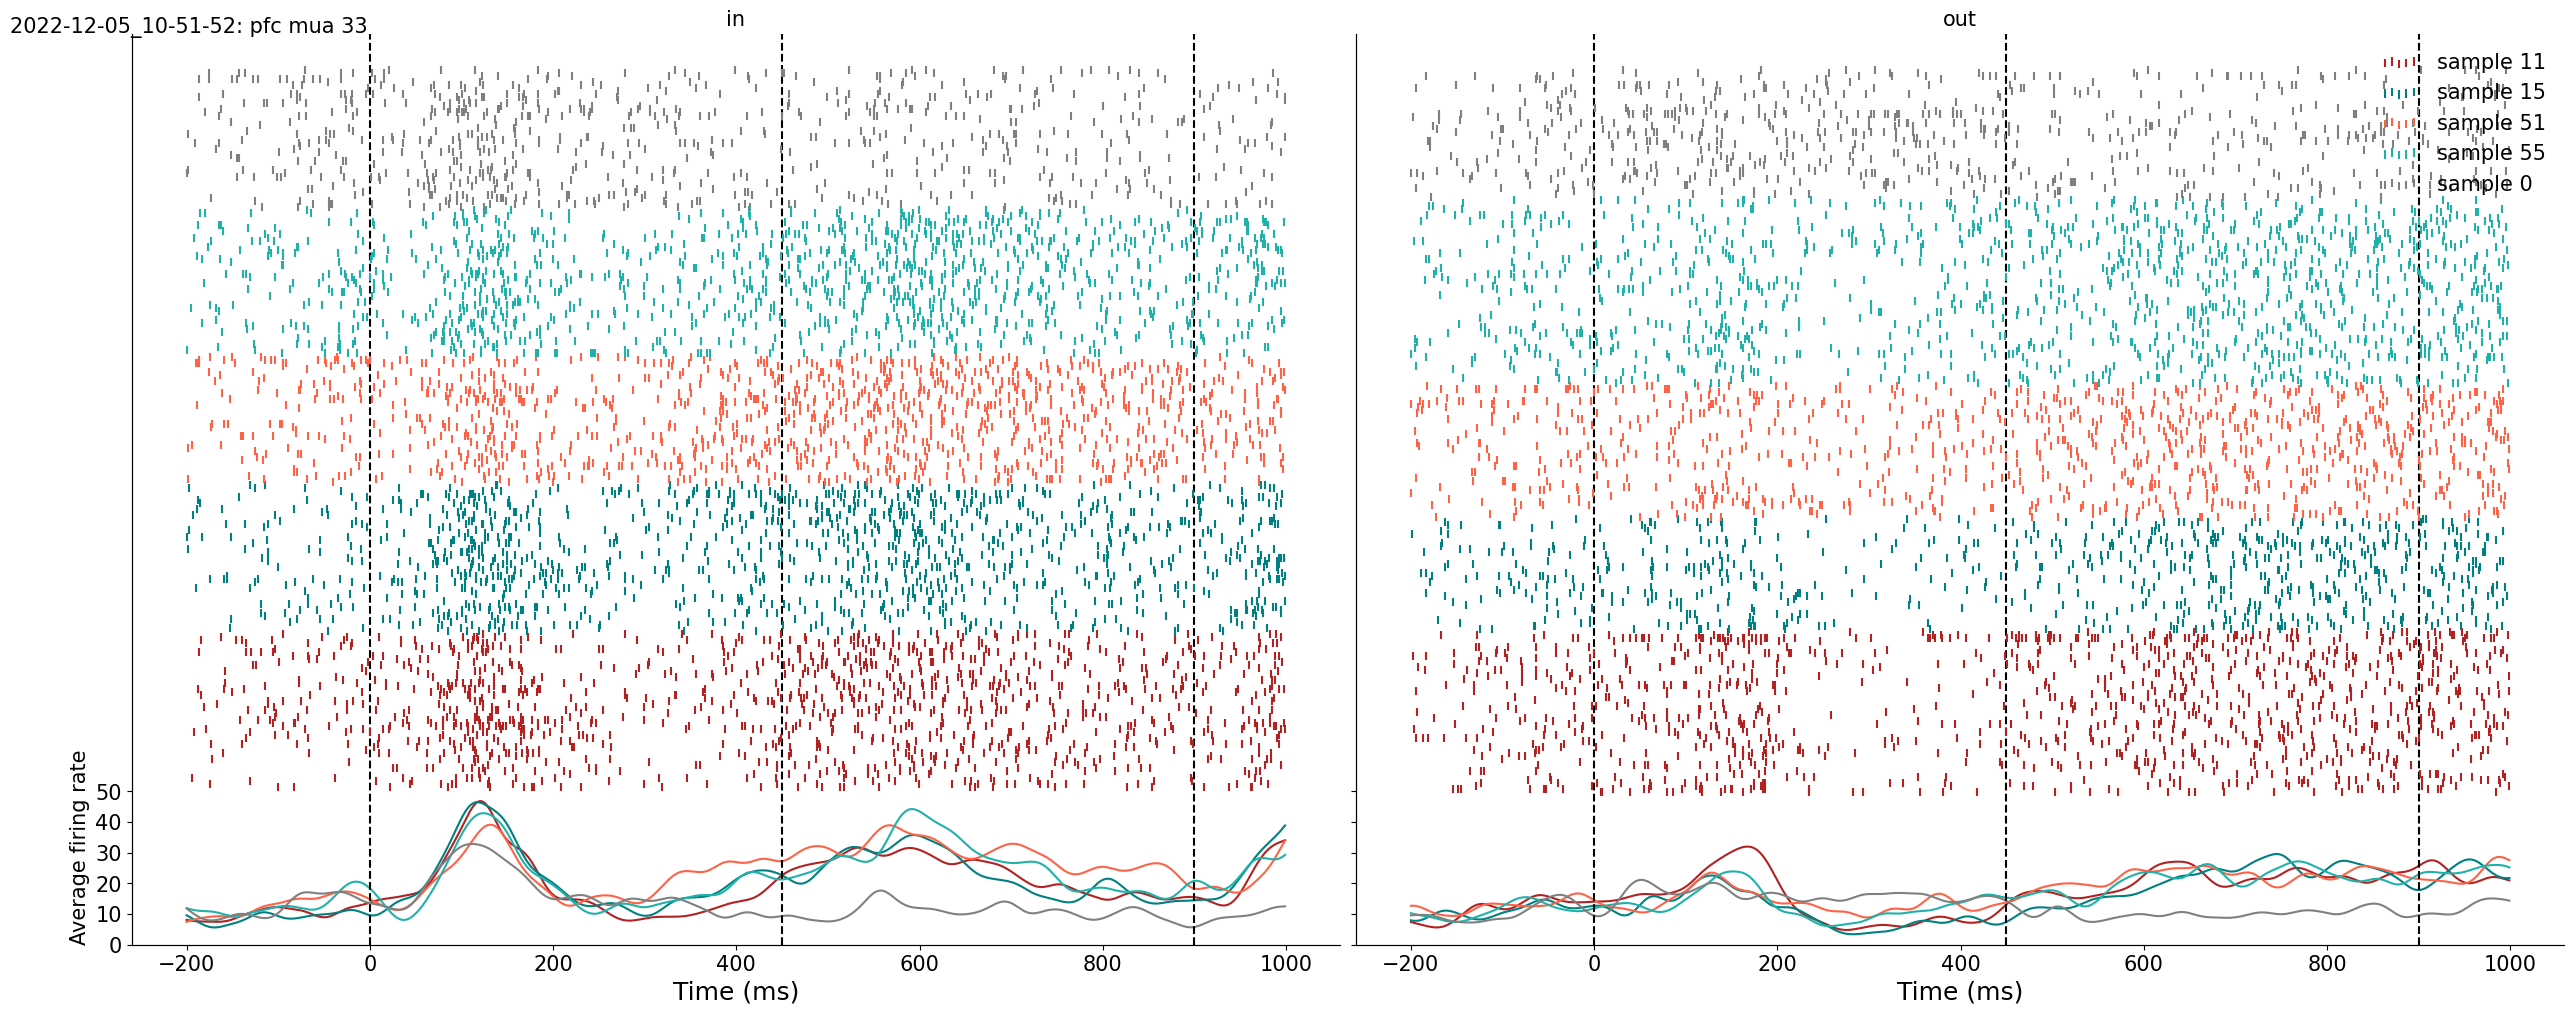

In [47]:
fig, (ax_in,ax_out) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), sharey=True)
#conv_in,conv_out=[],[]
time = np.arange(0,end-start)+start
ax_in_2 = ax_in.twinx()
pos= 'in'
ax_in, ax_in_2,n_trials_in=plot_raster_conv(all_sp_by_sample[pos],start,conv_all[pos],time,ax_in,ax_in_2,colors=colors)
ax_out_2 = ax_out.twinx()  
pos= 'out'
ax_out, ax_out_2,n_trials_out=plot_raster_conv(all_sp_by_sample[pos],start,conv_all[pos],time,ax_out,ax_out_2,colors=colors)

all_max_trial=max([n_trials_in,n_trials_out])
# -----parameters in plot
ax_in_2.axes.set_yticks(np.arange(-all_max_conv-5, all_max_trial))
ax_in.axes.set_ylim(0,all_max_conv+all_max_trial+5)
ax_in.axes.set_yticks(np.arange(0, all_max_conv+5,10))
plt.setp(ax_in_2.axes.get_yticklabels(), visible=False)
plt.setp(ax_in_2.axes.get_yaxis(), visible=False)
ax_in.set_title('in',fontsize=15)
ax_in.vlines(
        [0,450,900],
        0,
        all_max_conv+all_max_trial+5,
        color='k',
        linestyles="dashed",
    )
ax_in.spines["right"].set_visible(False)
ax_in.spines["top"].set_visible(False)
ax_in_2.spines["right"].set_visible(False)
ax_in_2.spines["top"].set_visible(False)
ax_in.set_xlabel(xlabel="Time (ms)",fontsize=18)
ax_in.set_ylabel(ylabel="Average firing rate",fontsize=15,loc="bottom")
for xtick in ax_in.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15)  
for ytick in ax_in.yaxis.get_major_ticks():
    ytick.label1.set_fontsize(15) 
for xtick in ax_in_2.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15) 
# -----parameters out plot
ax_out_2.axes.set_yticks(np.arange(-all_max_conv-5, all_max_trial))
ax_out.axes.set_ylim(0,all_max_conv+all_max_trial+5)
ax_out.axes.set_yticks(np.arange(0, all_max_conv+5,10))
plt.setp(ax_out_2.axes.get_yticklabels(), visible=False)
plt.setp(ax_out_2.axes.get_yaxis(), visible=False)
ax_out.set_title('out',fontsize=15)
ax_out.vlines(
        [0,450,900],
        0,
        all_max_conv+all_max_trial+5,
        color='k',
        linestyles="dashed",
    )
ax_out.spines["right"].set_visible(False)
ax_out.spines["top"].set_visible(False)
ax_out_2.spines["right"].set_visible(False)
ax_out_2.spines["top"].set_visible(False)
ax_out.set_xlabel(xlabel="Time (ms)",fontsize=18)
for xtick in ax_out.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15)  
for ytick in ax_out.yaxis.get_major_ticks():
    ytick.label1.set_fontsize(15) 
for xtick in ax_out_2.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15) 
ax_out_2.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
## --- figure
fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
fig.suptitle("%s: %s %s %d " % (neu_data.date_time, neu_data.area, neu_data.cluster_group, neu_data.cluster_number), x=0.05, y=0.99,fontsize=15)

In [48]:
# fig.savefig("V4_b1.png",format='png',bbox_inches="tight", transparent=True)
# fig.savefig("V4_b1.svg",format='svg',bbox_inches="tight", transparent=True)

#### Check sample selectiviy


## Stats

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
from sklearn.multiclass import OneVsRestClassifier
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
seed = 2023

ModuleNotFoundError: No module named 'bioinfokit'

In [ ]:
n_neuron = 8

## SVM

#### def functions

In [ ]:
def run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value):
    scores = np.zeros((n_iterations,steps))
    for n_it in np.arange(n_iterations):
        #  select trials randomly
        df = []
        for i_df in list_df:
            df.append(i_df.sample(resample_value,random_state=it_seed[n_it],replace=False)) # sample without replacement
        df = pd.concat(df).reset_index(drop=True)
        
        #df = df.sample(frac=1,random_state=it_seed[n_it],replace=False)
        
        X = df.iloc[:, :-4] 
        #X = pd.DataFrame(scaler.fit_transform(X))
        y = df['label_encoder']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
        X_train['label_encoder'] = y_train
        #X_test['label_encoder'] = y_test
        # Sample with replacement
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=False)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        for n,n_win in enumerate(np.arange(0,steps*win_steps,win_steps)):
            # Split into X and y
            scaler = MinMaxScaler()
            X = X_train.iloc[:,int(n_win):int(n_win)+win_size].mean(axis=1).values.reshape(-1, 1)
            X = pd.DataFrame(scaler.fit_transform(X))    
            # test
            X_t = X_test.iloc[:,int(n_win):int(n_win)+win_size].mean(axis=1).values.reshape(-1, 1)        
            X_t = pd.DataFrame(scaler.transform(X_t))
            model.fit(X,y_train)
            y_predict = model.predict(X_t)
            scores[n_it, n] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [ ]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

#### Model

In [ ]:
# define model
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)
# data preparation
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
n_iterations = 10
win_steps = 10
win_size = 100
steps = int(np.ceil((len(neuron_fr.columns[:-4])/win_steps)))
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)

NameError: name 'fr_samples' is not defined

In [ ]:
# encode labels
le = LabelEncoder()
le.fit(neuron_fr['sample'].replace(['B','C','D'],'A').values)
neuron_fr['label_encoder'] = le.transform(neuron_fr.loc[:,'sample'].replace(['B','C','D'],'A').values) # encode labels
# Resample dataframe
resample_value = neuron_fr[neuron_fr['sample']=='N']['sample'].value_counts().min()
list_df=[neuron_fr[(neuron_fr['sample'] == 'A') | (neuron_fr['sample'] == 'B') | (neuron_fr['sample'] == 'C') | (neuron_fr['sample'] == 'D')],neuron_fr[neuron_fr['sample'] == 'N']]

In [ ]:
scores = run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value)
plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron)

#### Predict samples

In [ ]:
# encode labels
le = LabelEncoder()
le.fit(neuron_fr['sample'].values)
neuron_fr['label_encoder'] = le.transform(neuron_fr['sample'].values) # encode labels
# Resample dataframe
resample_value = neuron_fr['sample'].value_counts().min()
list_df=[neuron_fr[neuron_fr['sample'] == 'A'],neuron_fr[neuron_fr['sample'] == 'B'],neuron_fr[neuron_fr['sample'] == 'C'],neuron_fr[neuron_fr['sample'] == 'D'],neuron_fr[neuron_fr['sample'] == 'N']]

In [ ]:
scores_samples = run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value)
plot_accuracy(scores_samples,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron)

## ANOVA

#### def functions

In [ ]:
def select_from_df(df1,samples,n_neuron,df2=np.nan):
    if isinstance(df2,pd.DataFrame) == False:
        df2=df1
    # add to check shapes of df1 == df2
    sample_df = []
    for s in samples:
        sample_df.append(df1[(df2['sample']==s)&(df2['neuron']==n_neuron)])
    return pd.concat(sample_df,axis=0)

In [ ]:
# t_test
def compute_f_oneway(group1,group2,group3,group4,neuron_max_shift,seed):
    foneway:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        trials_group3 = group3.iloc[:,n_win]
        trials_group4 = group4.iloc[:,n_win]
        #trials_group5 = group5.iloc[:,n_win]
        p=stats.f_oneway(trials_group1.values, trials_group2.values,trials_group3.values, trials_group4.values)#,trials_group5.values)
        foneway['p']+=[p[1]]
        
    foneway=pd.DataFrame(foneway)
    fig,ax=plt.subplots(figsize=(10,3))
    bonferroni_foneway = multipletests(foneway.values.reshape(-1),alpha=0.05)[1]
    mask_b = bonferroni_foneway<0.05
    mask_f = foneway.values.reshape(-1)<0.05
    ax.plot((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000,foneway.values.reshape(-1))
    ax.scatter(((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000)[mask_f],foneway.values.reshape(-1)[mask_f],c='b',marker='.')
    ax.plot((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000,bonferroni_foneway)
    ax.scatter(((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000)[mask_b],bonferroni_foneway[mask_b],c='firebrick',marker='.')

    return foneway

#### compute anova

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 500
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()

In [ ]:
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
#n = select_from_df(df1=mean_fr_window,samples=['N'],n_neuron=n_neuron,df2=neuron_fr)
foneway = compute_f_oneway(a,b,c,d,neuron_max_shift,seed)


## t test

#### def functions

In [ ]:
# t_test
def compute_t_test(group1,group2,neuron_max_shift,seed):
    t_test:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        p=stats.ttest_ind(trials_group1.values, trials_group2.values)
        t_test['p']+=[p[1]]
        
    t_test=pd.DataFrame(t_test)
    fig,ax=plt.subplots(figsize=(10,3))
    bonferroni_t_test = multipletests(t_test.values.reshape(-1),alpha=0.05)[1]
    mask_b = bonferroni_t_test<0.05
    mask_t = t_test.values.reshape(-1)<0.05
    ax.plot((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000,t_test.values.reshape(-1))
    ax.scatter(((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000)[mask_t],t_test.values.reshape(-1)[mask_t],c='b',marker='.')
    ax.plot((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000,bonferroni_t_test)
    ax.scatter(((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000)[mask_b],bonferroni_t_test[mask_b],c='firebrick',marker='.')
    ax.set(xlabel="Time (s)", ylabel="p-value")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['t-test','values under 0.05','bonferroni','values under 0.05'], fontsize=8)
    return t_test


#### compute t-test

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 500
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()

In [ ]:
# test whether the neuron is engaged in the task (N vs others)
all_sample_presentation = select_from_df(df1=mean_fr_window,samples=['A','B','C','D'],n_neuron=n_neuron,df2=neuron_fr)
n_sample_presentation = select_from_df(df1=mean_fr_window,samples=['N'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(all_sample_presentation,n_sample_presentation,neuron_max_shift,seed)

#### Check if it is sample selective
The neuron is sample selective only if it is significant for one of the following (a vs d | b vs c):

In [ ]:
# Color - orientation 1
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,d,neuron_max_shift,seed)

In [ ]:
# Color - orientation 2 
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(b,c,neuron_max_shift,seed)

In [ ]:
# Orientation 
ab = select_from_df(df1=mean_fr_window,samples=['A','B'],n_neuron=n_neuron,df2=neuron_fr)
cd = select_from_df(df1=mean_fr_window,samples=['C','D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(ab,cd,neuron_max_shift,seed)

In [ ]:
# Color
ac = select_from_df(df1=mean_fr_window,samples=['A','C'],n_neuron=n_neuron,df2=neuron_fr)
bd = select_from_df(df1=mean_fr_window,samples=['B','D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(ac,bd,neuron_max_shift,seed)

In [ ]:
# A vs C (same color)
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,c,neuron_max_shift,seed)

In [ ]:
# A vs B (same orientation)
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,b,neuron_max_shift,seed)

In [ ]:
# C vs D (same orientation)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,c,neuron_max_shift,seed)

## index

#### Def functions

In [ ]:
# index
def compute_index(group1,group2,neuron_max_shift,seed):
    index:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        if trials_group1.mean!=0 or trials_group2.mean()!=0:
            if trials_group1.mean()>trials_group2.mean():
                pref = trials_group1
                n_pref = trials_group2
                g=0
            else:
                pref = trials_group2
                n_pref = trials_group1 
                g=1
            index['idx']+=[(pref.mean()-n_pref.mean())/(pref.mean()+n_pref.mean())]#np.sqrt((pref.var()+n_pref.var())/2)
            index['group'] += [g]
        else:
            index['idx']+=[0]
            index['group'] += [0.5]
        
    index=pd.DataFrame(index)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot((np.arange(len(index))-neuron_max_shift[0]/step)/1000,index['idx'].values.reshape(-1))
    ax.plot((np.arange(len(index))-neuron_max_shift[0]/step)/1000,index['group'].values.reshape(-1))    
    return index

#### Compute index

In [ ]:
index=compute_index(a,d,neuron_max_shift,seed)

## ROC AUC score

#### Def functions

In [ ]:
def compute_roc_auc(group1,group2):
    roc_score:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
    for n_win in np.arange(a.shape[1]):
        g1 = group1.iloc[:,n_win]
        g2 = group2.iloc[:,n_win]
        min_fr, max_fr = pd.concat((g1,g2)).min(),pd.concat((g1,g2)).max()
        thresholds = np.arange(min_fr,max_fr+0.01,0.01)
        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1.values>=threshold,g2.values>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            idx_sort=fpr.argsort()
            score = metrics.auc(fpr[idx_sort],tpr[idx_sort])
            roc_score['score']+=[score]
        else:
            roc_score['score']+=[0.5]
    roc_score=pd.DataFrame(roc_score)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot((np.arange(len(roc_score))-neuron_max_shift[0]/step)/1000,roc_score['score'].values.reshape(-1))   
    ax.set(xlabel="Time (s)", ylabel="ROC AUC score")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    
    return roc_score


#### Compute roc

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 100
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
roc_score =compute_roc_auc(a,d)

In [ ]:
ac = select_from_df(df1=mean_fr_window,samples=['A','C'],n_neuron=n_neuron,df2=neuron_fr)
bd = select_from_df(df1=mean_fr_window,samples=['B','D'],n_neuron=n_neuron,df2=neuron_fr)
roc_score = compute_roc_auc(ac,bd)